In [1]:
#Import dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
'''
base = VGG19(weights='imagenet')
#vgg19_feature_extractor = Model(inputs=base.inputs, outputs=base.layers[-3].output)
#vgg19_feature_extractor.summary()

# Store the fully connected layers
fc1 = base.layers[-4]
d1 = Dense(4096, activation='sigmoid')(fc1.output)

vgg19_feature_extractor = Model(inputs=base.inputs, outputs=d1)
vgg19_feature_extractor.summary()
'''

model = VGG19(weights='imagenet')
#model.summary()

# Store the fully connected layers
fc1 = model.layers[-3]
fc2 = model.layers[-2]
predictions = model.layers[-1]

# Create the dropout layers
dropout1 = Dropout(0.20)
dropout2 = Dropout(0.20)

# Reconnect the layers
x1 = dropout1(fc1.output)
x2 = fc2(x1)
x3 = dropout2(x2)
x4 = Dense(4096, activation='sigmoid')(x3)
predictors = predictions(x4)

# Create a new model
model2 = Model(inputs=model.inputs, outputs=predictors)

vgg19_feature_extractor = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)

vgg19_feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(224,224,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    distances = siamese_layer(vgg19_feature_extractor(input_image), vgg19_feature_extractor(validation_image))
    
    # Classification layer 
    #classifier = Dense(1, activation='sigmoid')(distances)
    classifier = Dense(1, activation='tanh')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [5]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (224,224))
    # Scale image to be between 0 and 1 
    #img = img / 255.0

    # Return image
    return img

def preprocess_twin(input_img, validation_img, label):
    return(tf.keras.applications.vgg19.preprocess_input(preprocess(input_img)), tf.keras.applications.vgg19.preprocess_input(preprocess(validation_img)), label)

In [6]:
#In this case the anchor is flooding true images, and the positive also flooding true and the negative is flooding false
PATH_TEST_1 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR'
PATH_TEST_2 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE'
PATH_TEST_3 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE'

a = tf.data.Dataset.list_files(PATH_TEST_1+'/*.png', shuffle = False).take(500)
b = tf.data.Dataset.list_files(PATH_TEST_2+'/*.png', shuffle = False).take(500)
c = tf.data.Dataset.list_files(PATH_TEST_3+'/*.png', shuffle = False).take(500)

a1 = a.as_numpy_iterator()
b1 = b.as_numpy_iterator()
c1 = c.as_numpy_iterator()

print(a1.next())
print(b1.next())
print(c1.next())
print('--------------------------')
print(a1.next())
print(b1.next())
print(c1.next())
print('--------------------------')

positives = tf.data.Dataset.zip((a, c, tf.data.Dataset.from_tensor_slices(tf.ones(len(a)))))
negatives = tf.data.Dataset.zip((a, b, tf.data.Dataset.from_tensor_slices(tf.zeros(len(a)))))
data = positives.concatenate(negatives)

b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR/img0.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE/img0.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE/img0.png'
--------------------------
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR/img1.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE/img1.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE/img1.png'
--------------------------


In [7]:
#THIS IS WHAT WAS PREVIOUSLY USED BEFORE THE CELL ABOVE, RETURN TO IT IF TESTING FAILS
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=220) #very important to shuffle data, since it may cause the model to overfit otherwise

# Training partition
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [8]:
siamese_model = make_siamese_model()
siamese_model.summary()
binary_cross_loss = tf.losses.BinaryCrossentropy()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 4096)         156351552   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [9]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [11]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [12]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy

metrics_plotting = {}
loss_arr = []
recall = []
precision = []
accuracy = []
def train(data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating metric objects
        r = Recall()
        p = Precision()
        a = BinaryAccuracy()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])

            #Printing calculated distance before post processing, i.e before rounding to 0 or 1
            print(yhat)

            yhat = [1 if ((prediction > -0.025) and (prediction < 0.025)) else 0 for prediction in yhat]
            temp = [1 if e == 1.0 else 0 for e in batch[2]]

            #Printing out more values
            print(yhat)
            print(temp)

            r.update_state(temp, yhat)
            p.update_state(temp, yhat) 
            a.update_state(temp, yhat) 

            progbar.update(idx+1)

        #Print out metrics    
        print(loss.numpy(), r.result().numpy(), p.result().numpy(), a.result().numpy())
        #metrics_plotting[epoch] = [loss.numpy(), r.result().numpy(), p.result().numpy(), a.result().numpy()]

        loss_arr.append(loss.numpy())
        recall.append(r.result().numpy())
        precision.append(p.result().numpy())
        accuracy.append(a.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
EPOCHS = 50
tf.config.run_functions_eagerly(True)
train(train_data, EPOCHS)


 Epoch 1/50
tf.Tensor(4.3813047, shape=(), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Streaming output truncated to the last 5000 lines.
 [-0.00543388]
 [-0.00814239]]
[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
 6/11 [===============>..............] - ETA: 2stf.Tensor(4.8202963, shape=(), dtype=float32)
[[-0.00068212]
 [-0.0463172 ]
 [-0.04560826]
 [-0.02200075]
 [-0.04717714]
 [-0.03002659]
 [-0.00378164]
 [-0.03916431]
 [-0.05100225]
 [-0.02967628]
 [-0.04302283]
 [-0.0853492 ]
 [-0.00901122]
 [-0.09355645]
 [-0.04594235]
 [-0.00458437]]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
 7/11 [==================>...........] - ETA: 1stf.Tensor(3.8562372, shape=(), dtype=float32)
[[-0.03630418]
 [-0.0214073 ]
 [-0.03702349]
 [-0.06415363]
 [-0.04164939]
 [-0.01411208]
 [ 0.00389729]
 [-0.06698597]
 [-0.00919217]
 [-0.01562651]
 [-0.00072919]
 [ 0.00716492]
 [-0.08192522]
 [-0.03498443]
 [-0.09253818]
 [-0.05167181]]
[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[1,

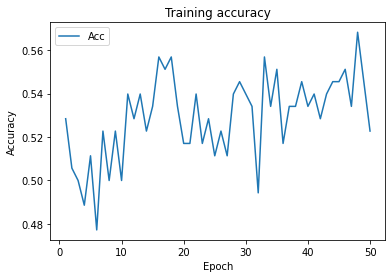

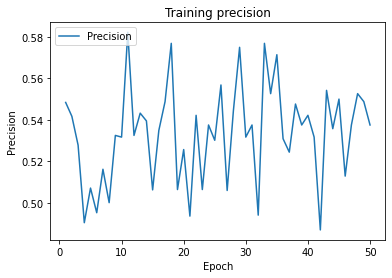

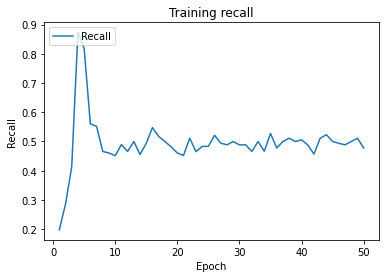

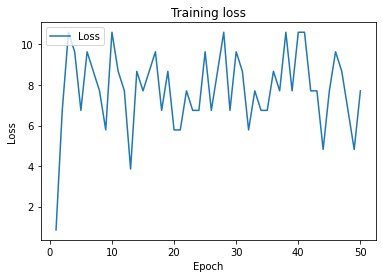

In [15]:
epochs_arr = []
for epoch in range(1, EPOCHS+1):
  epochs_arr.append(epoch)

# summarize history for accuracy
plt.plot(epochs_arr, accuracy)
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Acc'], loc='upper left')
plt.savefig('/content/drive/MyDrive/VGG19/Acc.png')
plt.show()

# summarize history for accuracy
plt.plot(epochs_arr, precision)
plt.title('Training precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Precision'], loc='upper left')
plt.savefig('/content/drive/MyDrive/VGG19/Precision.png')
plt.show()

# summarize history for accuracy
plt.plot(epochs_arr, recall)
plt.title('Training recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Recall'], loc='upper left')
plt.savefig('/content/drive/MyDrive/VGG19/Recall.png')
plt.show()

# summarize history for accuracy
plt.plot(epochs_arr, loss_arr)
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.savefig('/content/drive/MyDrive/VGG19/Loss.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
------------------------------------------------
11
8
14
11
------------------------------------------------
0.5681818181818182
0.5 0.57894737 0.5694444


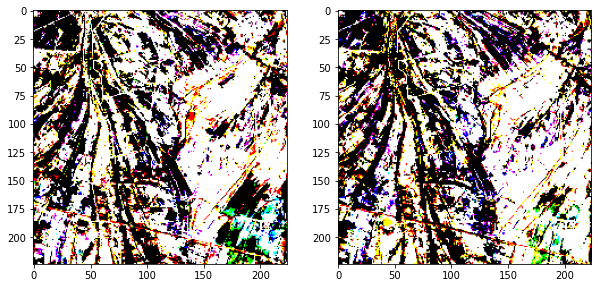

In [18]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

r = Recall()
p = Precision()
a = BinaryAccuracy()

val_accuracy = []
val_loss_arr = []
val_recall = []
val_precision = []

true_and_true = 0
true_and_false = 0
false_and_false = 0
false_and_true = 0
total = 0 
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    
    yhat = siamese_model.predict([test_input, test_val])
    
    yhat = [1 if ((prediction > -0.025) and (prediction < 0.025)) else 0 for prediction in yhat] #USED FOR TANH ACTIVATION OF DISTANCES
    temp = [1 if e == 1.0 else 0 for e in y_true]

    for e, i in zip(yhat, temp):
      total += 1
      if e == 1 and i == 1:
        #true positive
        true_and_true += 1
      elif e == 1 and i == 0:
        #false positive
        true_and_false += 1
      elif e == 0 and i == 0:
        #true negative
        false_and_false += 1
      elif e == 0 and i == 1:
        #false negative
        false_and_true += 1

    r.update_state(temp,yhat)
    p.update_state(temp,yhat) 
    a.update_state(temp,yhat)

    print(temp)
    print(yhat)

print("------------------------------------------------")
print(true_and_true)
print(true_and_false)
print(false_and_false)
print(false_and_true)
print("------------------------------------------------")

acc = (true_and_true + false_and_false)/total
print(acc)

print(r.result().numpy(), p.result().numpy(), a.result().numpy())

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [19]:
import csv

with open('/content/drive/MyDrive/VGG19/confusion_matrix.csv', 'w', newline ='') as csvfile:
  
    header = ['true_true', 'true_false', 'false_false', 'false_true', 'recall', 'precision', 'accuracy']
    data = [str(true_and_true), str(true_and_false), str(false_and_false), str(false_and_true), str(r.result().numpy()), str(p.result().numpy()), str(a.result().numpy())]

    writer = csv.writer(csvfile)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)

    csvfile.close()